# Numpy Example

In this script, we first simulated an image of the sky by adding a number of
Gaussian stars. Then we look for the brightest star in the field and extract
the measured flux. We compare the measured flux as a function of aperture size.


In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from collections import namedtuple

In [3]:
import logging

logging.basicConfig(level=logging.INFO) # Default level is WARNING

In [4]:
ImageSize = namedtuple("ImageSize", "width height")

Set input parameters:

In [54]:
np.random.seed(10001)
image_size = ImageSize(1000, 1200)
number_of_stars = 50
bias = 100.
noise = 1.

Define a function that a Gaussian PSF of a star.

In [55]:
def star_image(image_coords, star_coords, sigma=1.0, peak_brightness=1.0):
    """
    Definition of the Gaussian PSF of a star. 
    """
    X,Y = image_coords
    star_x,star_y = star_coords
    starshape = peak_brightness * np.exp( -0.5*((X-star_x)**2 + (Y-star_y)**2) / sigma**2)
    logging.debug(f"Added star at {star_coords} (sigma={sigma:.2f}, peak={peak_brightness:.2f})")
    return starshape

In [56]:
#-- start with a bias image

image = bias*np.ones(image_size)

#-- create a coordinate grid of the image to easily compute distances etc.

X,Y = np.mgrid[0:image_size.width:1,0:image_size.height:1]

#-- create a set of random parameters to characterize the input stars.
#   This table consists of 'number_of_star' rows and 4 columns:
#       Column 0: X coordinate of star
#       Column 1: Y coordinate of star
#       Column 2: width of star
#       Column 3: star brightness

stars = np.random.uniform(low=np.array([0, 0, 5.2, 5]),
                          high=np.array([image_size.width, image_size.height, 5.5, 100]),
                          size=(number_of_stars, 4))

#-- See where the brightest star is located and what its total flux is.

brightest_star_input = np.argmax(stars[:,3])
predicted_flux = 2*np.pi*stars[brightest_star_input,2]**2*stars[brightest_star_input,3]

#-- now add all the input stars to the image

for star in stars:
    image += star_image((X,Y),star[:2],sigma=star[2],peak_brightness=star[3])

#-- and add some random noise the image

image += np.random.normal(size=image.shape, scale=noise)


Extract the brightest star from the simulated image.

In [57]:
#-- first determine the bias

bias_meas = np.median(np.ravel(image))

#-- get the location of the brightest star

Xc,Yc = np.unravel_index(image.argmax(),image.shape)
logging.info (f"Location of brightest star: {Xc}, {Yc}")

#-- determine the distance from each pixel to the brightest star: we want to 
#   sum up all flux inside a region around the brightest stars (an aperture).
#   We will use different aperture sizes to see how the measured flux is
#   dependent on it

distance = np.sqrt( (X-Xc)**2 + (Y-Yc)**2)
apertures = np.linspace(0.5,5,10)*stars[:,-2].mean()

#-- prepare an array to collect the measured fluxes as a function of aperture

measured_fluxes = np.zeros_like(apertures)

#-- now sum up the flux inside each aperture. Therefore, copy the original
#   image into a new array, and set all the flux outside the aperture to zero.
#   Then, subtract the bias and sum the whole

for i,aperture in enumerate(apertures):
    brightest_star = distance<=aperture
    extracted = image+0.
    extracted[~brightest_star] = 0
    extracted[brightest_star] -= bias_meas
    measured_fluxes[i] = extracted.sum()
    logging.info(f"Aperture {aperture:.4f}: flux = {measured_fluxes[i]:.4f} (real = {predicted_flux}")

INFO:root:Location of brightest star: 589, 999
INFO:root:Aperture 2.6726: flux = 1970.7356 (real = 17358.370945740284
INFO:root:Aperture 5.3452: flux = 6914.2148 (real = 17358.370945740284
INFO:root:Aperture 8.0178: flux = 11693.3699 (real = 17358.370945740284
INFO:root:Aperture 10.6904: flux = 15073.9531 (real = 17358.370945740284
INFO:root:Aperture 13.3630: flux = 16628.5032 (real = 17358.370945740284
INFO:root:Aperture 16.0356: flux = 17177.9484 (real = 17358.370945740284
INFO:root:Aperture 18.7082: flux = 17359.9854 (real = 17358.370945740284
INFO:root:Aperture 21.3808: flux = 17378.9710 (real = 17358.370945740284
INFO:root:Aperture 24.0535: flux = 17374.8097 (real = 17358.370945740284
INFO:root:Aperture 26.7261: flux = 17341.0183 (real = 17358.370945740284


Make a plot of the measured/predicted fluxes.

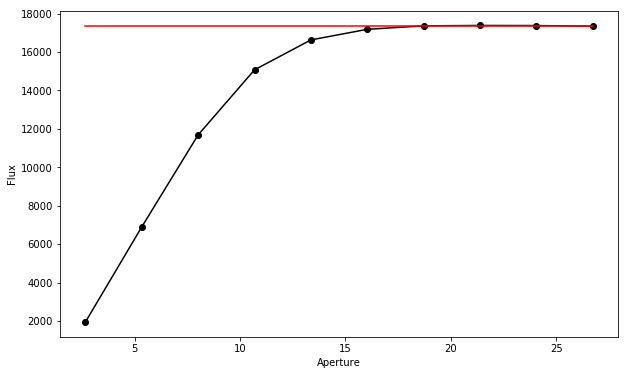

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(apertures, measured_fluxes, 'ko-')
plt.plot(apertures, np.ones_like(apertures)*predicted_flux, 'r-')
plt.xlabel("Aperture")
plt.ylabel("Flux");

Make a plot of the image itself and the extracted region.

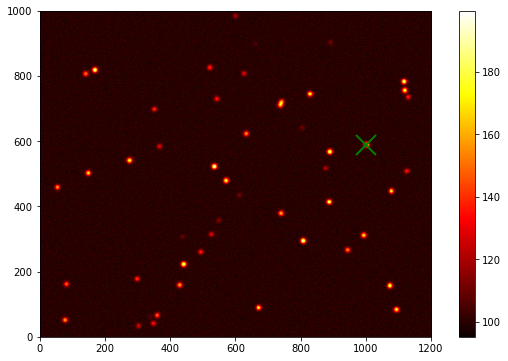

In [59]:
plt.figure(figsize=(10,6))
plt.imshow(image, cmap=plt.cm.hot)
plt.plot(Yc,Xc,'gx',ms=20,mew=2)
plt.colorbar()
plt.xlim(0,image_size.height)
plt.ylim(0,image_size.width);

Don't plot the flux outside the extracted region.

In [60]:
extracted[~brightest_star] = np.nan

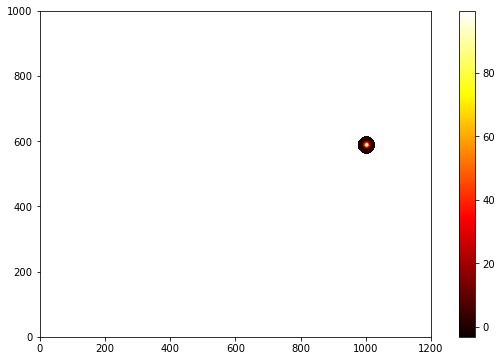

In [61]:
plt.figure(figsize=(10,6))
plt.imshow(extracted, cmap=plt.cm.hot)
plt.colorbar()
plt.xlim(0,image_size[1])
plt.ylim(0,image_size[0]);